In [ ]:
from tensorflow.keras.datasets import mnist

import numpy as np
import tensorflow as tf

In [32]:
# Load and preprocess MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
fraction = 0.2
train_size = int(len(X_train) * fraction)
test_size = int(len(X_test) * fraction)

# Shuffle and take a subset
np.random.seed(42)  # For reproducibility
train_indices = np.random.choice(len(X_train), train_size, replace=False)
test_indices = np.random.choice(len(X_test), test_size, replace=False)

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension: (28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)

# Convert grayscale to RGB by repeating channels
X_train = np.repeat(X_train, 3, axis=-1)  # Shape: (28, 28, 3)
X_test = np.repeat(X_test, 3, axis=-1)

In [33]:
X_train = tf.image.resize(X_train, (150, 150))
X_test = tf.image.resize(X_test, (150, 150))

# Normalize the images
X_train, X_test = X_train / 255.0, X_test / 255.0

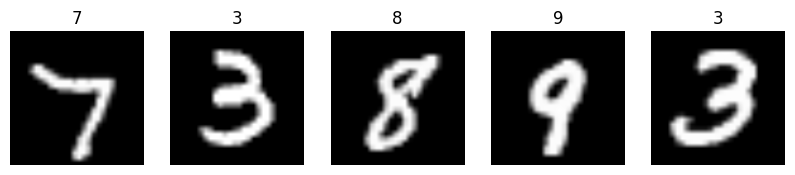

In [34]:
import matplotlib.pyplot as plt

def display_samples(images, labels, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

display_samples(X_train, y_train)

In [35]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import models

def build_transfer_model(base_model, neurons=128, dropout_rate=0.3):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

In [36]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [46]:
from tensorflow.keras.optimizers import Adam

def compile_and_train(model, learning_rate, batch_size, epochs=2):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=2, batch_size=batch_size, verbose=1)
    return history

In [47]:
from tensorflow.keras.applications import VGG16, ResNet50

experiments = [
    (VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)), 'VGG16'),
    (ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)), 'ResNet50')
]

In [48]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

In [49]:
configs = [ (0.001, 32, 128), (0.0005, 64, 64)]

for base_model, model_name in experiments:
    print(f"\nEvaluating {model_name}\n")
    for lr, batch, neurons in configs:
        print(f"\nlearning_rate={lr}, batch_size={batch}, neurons={neurons}")
        model = build_transfer_model(base_model, neurons=neurons)
        history = compile_and_train(model, learning_rate=lr, batch_size=batch)
        plot_metrics(history)
        test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n")


Evaluating VGG16


learning_rate=0.001, batch_size=32, neurons=128
Epoch 1/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 2180s 6s/step - accuracy: 0.1126 - loss: -513.9891 - val_accuracy: 0.1165 - val_loss: -4481.2163
Epoch 2/2
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1110 - loss: -7270.3545

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history_fine = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=5, batch_size=32, verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

<ipython-input-17-d3b52c10f465>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6487 - loss: 0.6490 - val_accuracy: 0.7767 - val_loss: 0.6444
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.6846 - loss: 0.6397 - val_accuracy: 0.7864 - val_loss: 0.6416
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6739 - loss: 0.6462 - val_accuracy: 0.7767 - val_loss: 0.6385
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7082 - loss: 0.6341 - val_accuracy: 0.7427 - val_loss: 0.6357
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.6845 - loss: 0.6364 - val_accuracy: 0.7621 - val_loss: 0.6333
Test Loss: 0.6333, Test Accuracy: 0.7621


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

cm = confusion_matrix(y_test_encoded, y_pred)
print(f"Confusion Matrix:\n{cm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step
Confusion Matrix:
[[80 20]
 [29 77]]


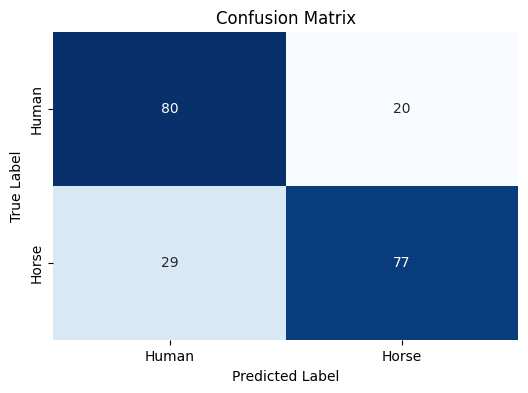

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Human', 'Horse'], yticklabels=['Human', 'Horse'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()